In [1]:
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

from sklearn import datasets
from sklearn.decomposition import PCA
import random

In [3]:
import os
import datetime 
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import tensorboard
import torchvision
#import tensorflow as tf

## Load data in class

In [4]:
#Make class from the dataset to use dataloader

from torch.utils.data import Dataset

class amino_acids(Dataset):
    res2num = {
        "ALA": 0, 
        "ASX": 1, 
        "CYS": 2, 
        "ASP": 3, 
        "GLU": 4, 
        "PHE": 5, 
        "GLY": 6, 
        "HIS": 7,
        "ILE": 8, 
        "LYS": 9, 
        "LEU": 10, 
        "MET": 11, 
        "ASN": 12, 
        "PRO": 13, 
        "GLN": 14,
        "ARG": 15, 
        "SER": 16, 
        "THR": 17, 
        "SEC": 18, 
        "VAL": 19, 
        "TRP": 20, 
        "XAA": 21,
        "TYR": 22, 
        "GLX": 23}
    
    old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN", 
             "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA","TYR", "GLX"]
    
    
    
    def __init__(self):#, split='train'):
        X = np.load('../dataset/theta_train_data.npy').astype(np.float32)
        y = np.load('../dataset/theta_train_target.npy').astype(np.int64)
        
        SPLITS = {'train': list(range(0,int(0.8*len(y)-1))), 
                        'val': list(range(int(0.8*len(y)),int(len(y))))} 
                        #'test': list(range(int(0.85*len(y)),(len(y))))}
        X_old = X
        n_obs = y.shape[0]
        nonzero_index = (~np.all(y == 0, axis = 0)).nonzero()[0]
        names = []
        for i in nonzero_index:
            names.append(self.old_names[i])
    
        # Then remove zero columns from 'y'
        y = y[:,~np.all(y == 0, axis = 0)]

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_old)
        # Added theta, so now 29 instead of 28 features per point
        X = X_scaled.reshape(n_obs, 100, 29)
        # Get integer values from one-hot encoding
        y_int = np.array([], dtype = np.int64)
        for i in y:
            y_int = np.concatenate((y_int, np.nonzero(i)[0]))

        # Save float and unique arrays of y_int
        y_float = y_int
        unique_y = np.unique(y_float)
        full_x_data = torch.from_numpy(X)
        full_y_data = torch.from_numpy(y_int)
        self.x_data = full_x_data#[SPLITS[split]]
        self.y_data = full_y_data#[SPLITS[split]]
        self.len = len(self.y_data)
        
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    

## Model

In [5]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 50, 1, stride=1)
        self.layer2 = nn.Linear(100, 20)
        self.drop_layer = nn.Dropout(p=0.5)
        self.layer3 = nn.Linear(1000, 100)
        self.layer4 = nn.Linear(100, 20)
        

        
    def forward(self, x):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = x.view(-1,50*20)
        x = self.drop_layer(x) # dropout module
        x = F.relu(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        
        return x

In [6]:
def reset_weights(m):
  '''
    Resetting the weights before each train-val run
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

dataset_train = amino_acids()
dataset_val = amino_acids(split = 'val')
trainloader = DataLoader(dataset_train, batch_size = 1000, shuffle = True, num_workers = 1)
valloader = DataLoader(dataset_val, batch_size = 1000, shuffle = True, num_workers = 1)

## Train val and test epochs

In [7]:
def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 
  for data in tqdm(trainloader):
     
    inputs,labels=data[0],data[1]
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
    #tb.add_scalar("Training Loss", running_loss, epoch)
    
  train_loss=running_loss/len(trainloader)
  train_accu=100.*correct/total
  
  #writer.add_scalar("Training Loss" + str(fold+1), train_loss, epoch)
  #writer.add_scalar("Training Correct", correct, epoch)
  #writer.add_scalar("Training Accuracy"+ str(fold+1), accu, epoch)
  #writer.flush()
    

   
  #train_accu.append(accu)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,train_accu))#train_losses.append(train_loss)
  return train_loss, train_accu
  

In [8]:

def validate(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for data in tqdm(valloader):
      inputs,labels=data[0],data[1]
       
      outputs=model(inputs)
 
      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
        
      
    
  val_loss=running_loss/len(valloader)
  val_accu=100.*correct/total
  #train_loss, train_accu = train(epoch)  
  #writer.add_scalar("Val Correct", correct, epoch)
  

  #eval_losses.append(val_loss)
  #eval_accu.append(accu)
 
  print('val Loss: %.3f | Accuracy: %.3f'%(val_loss,val_accu)) 
  return val_loss, val_accu
  

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(train_accu)
ax1.set_ylabel("train accuracy")
ax2.plot(eval_accu)
ax2.set_ylabel("val accuracy")
ax2.set_xlabel("epochs");

epochs=10
for epoch in range(1,epochs+1): 
  train(epoch)
  validate(epoch)

In [9]:
# Define the K-fold Cross Validator
dataset   = amino_acids()
model     = Model(dataset.x_data.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
k_folds = 4
epochs = 20
kfold = KFold(n_splits=k_folds, shuffle=True)

## Tensorboard

In [16]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
#logdir = os.path.join("runs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir=runs --port=2222
#%tensorboard logdir --host 0.0.0.0

Reusing TensorBoard on port 2222 (pid 21426), started 0:04:51 ago. (Use '!kill 21426' to kill it.)

## Run run run

In [10]:
writer = SummaryWriter()
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    reset_weights(model)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    trainloader = DataLoader(dataset, batch_size = 1000, sampler=train_subsampler)
    valloader = DataLoader(dataset, batch_size = 200, sampler=val_subsampler)
    print('Current Fold is:', fold+1)
    for epoch in range(1,epochs+1): 
        train_loss, train_accu = train(epoch)
        
        val_loss, val_accu = validate(epoch)
        
        writer.add_scalars("Train/Val Loss" + str(fold+1), {'train loss':train_loss, 'val loss': val_loss}, epoch)
        writer.add_scalars("Train/Val Accuracy"+ str(fold+1), {'train accu':train_accu,'val accu':val_accu}, epoch)
        writer.flush()
        
writer.close()

Reset trainable parameters of layer = Conv1d(29, 50, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=1000, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Current Fold is: 1

Epoch : 1


  0%|                                                                                            | 0/34 [00:00<?, ?it/s]/home/jzeng/env540/python_env/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.25it/s]


Train Loss: 2.897 | Accuracy: 9.614


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 125.02it/s]


val Loss: 2.859 | Accuracy: 10.353

Epoch : 2


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.82it/s]


Train Loss: 2.835 | Accuracy: 13.140


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 130.45it/s]


val Loss: 2.796 | Accuracy: 15.893

Epoch : 3


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.86it/s]


Train Loss: 2.790 | Accuracy: 15.520


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 132.27it/s]


val Loss: 2.769 | Accuracy: 16.953

Epoch : 4


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.22it/s]


Train Loss: 2.765 | Accuracy: 17.304


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 122.88it/s]


val Loss: 2.750 | Accuracy: 18.272

Epoch : 5


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.84it/s]


Train Loss: 2.748 | Accuracy: 18.797


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 134.68it/s]


val Loss: 2.732 | Accuracy: 19.790

Epoch : 6


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.35it/s]


Train Loss: 2.732 | Accuracy: 19.899


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 132.11it/s]


val Loss: 2.723 | Accuracy: 20.374

Epoch : 7


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.82it/s]


Train Loss: 2.728 | Accuracy: 20.369


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.79it/s]


val Loss: 2.726 | Accuracy: 21.891

Epoch : 8


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.35it/s]


Train Loss: 2.721 | Accuracy: 20.830


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 131.28it/s]


val Loss: 2.713 | Accuracy: 23.229

Epoch : 9


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.85it/s]


Train Loss: 2.713 | Accuracy: 21.961


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.92it/s]


val Loss: 2.714 | Accuracy: 23.426

Epoch : 10


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.22it/s]


Train Loss: 2.706 | Accuracy: 21.979


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 128.13it/s]


val Loss: 2.705 | Accuracy: 23.992

Epoch : 11


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.82it/s]


Train Loss: 2.701 | Accuracy: 22.922


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.47it/s]


val Loss: 2.706 | Accuracy: 23.328

Epoch : 12


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.77it/s]


Train Loss: 2.701 | Accuracy: 22.006


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 125.53it/s]


val Loss: 2.709 | Accuracy: 23.184

Epoch : 13


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.18it/s]


Train Loss: 2.702 | Accuracy: 22.081


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 127.90it/s]


val Loss: 2.705 | Accuracy: 23.821

Epoch : 14


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.83it/s]


Train Loss: 2.700 | Accuracy: 21.991


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.01it/s]


val Loss: 2.705 | Accuracy: 23.022

Epoch : 15


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.30it/s]


Train Loss: 2.698 | Accuracy: 21.581


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 125.71it/s]


val Loss: 2.713 | Accuracy: 22.115

Epoch : 16


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.18it/s]


Train Loss: 2.697 | Accuracy: 22.012


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 126.96it/s]


val Loss: 2.700 | Accuracy: 23.238

Epoch : 17


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.73it/s]


Train Loss: 2.696 | Accuracy: 21.808


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 132.23it/s]


val Loss: 2.704 | Accuracy: 21.963

Epoch : 18


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.04it/s]


Train Loss: 2.695 | Accuracy: 22.099


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 125.82it/s]


val Loss: 2.702 | Accuracy: 22.807

Epoch : 19


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.54it/s]


Train Loss: 2.707 | Accuracy: 21.102


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.67it/s]


val Loss: 2.718 | Accuracy: 21.280

Epoch : 20


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.15it/s]


Train Loss: 2.702 | Accuracy: 21.117


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 123.88it/s]


val Loss: 2.706 | Accuracy: 21.271
Reset trainable parameters of layer = Conv1d(29, 50, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=1000, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Current Fold is: 2

Epoch : 1


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.77it/s]


Train Loss: 2.958 | Accuracy: 6.385


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 123.97it/s]


val Loss: 2.948 | Accuracy: 4.965

Epoch : 2


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.29it/s]


Train Loss: 2.949 | Accuracy: 6.519


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 123.98it/s]


val Loss: 2.924 | Accuracy: 9.859

Epoch : 3


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.90it/s]


Train Loss: 2.898 | Accuracy: 10.665


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 132.83it/s]


val Loss: 2.858 | Accuracy: 13.469

Epoch : 4


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.31it/s]


Train Loss: 2.857 | Accuracy: 13.137


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 125.69it/s]


val Loss: 2.836 | Accuracy: 14.384

Epoch : 5


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.79it/s]


Train Loss: 2.836 | Accuracy: 13.544


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 132.04it/s]


val Loss: 2.819 | Accuracy: 14.483

Epoch : 6


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.95it/s]


Train Loss: 2.818 | Accuracy: 14.128


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.14it/s]


val Loss: 2.804 | Accuracy: 15.597

Epoch : 7


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.33it/s]


Train Loss: 2.809 | Accuracy: 14.933


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 126.19it/s]


val Loss: 2.790 | Accuracy: 15.372

Epoch : 8


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.82it/s]


Train Loss: 2.799 | Accuracy: 14.951


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.87it/s]


val Loss: 2.786 | Accuracy: 16.270

Epoch : 9


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.37it/s]


Train Loss: 2.791 | Accuracy: 15.517


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.22it/s]


val Loss: 2.774 | Accuracy: 16.198

Epoch : 10


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.84it/s]


Train Loss: 2.779 | Accuracy: 16.837


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.12it/s]


val Loss: 2.765 | Accuracy: 17.455

Epoch : 11


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.84it/s]


Train Loss: 2.771 | Accuracy: 16.804


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.34it/s]


val Loss: 2.760 | Accuracy: 17.419

Epoch : 12


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.24it/s]


Train Loss: 2.763 | Accuracy: 17.926


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 123.97it/s]


val Loss: 2.760 | Accuracy: 18.201

Epoch : 13


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.86it/s]


Train Loss: 2.766 | Accuracy: 17.699


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.07it/s]


val Loss: 2.766 | Accuracy: 18.676

Epoch : 14


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.21it/s]


Train Loss: 2.764 | Accuracy: 18.121


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 125.27it/s]


val Loss: 2.753 | Accuracy: 18.425

Epoch : 15


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.74it/s]


Train Loss: 2.756 | Accuracy: 18.597


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.77it/s]


val Loss: 2.743 | Accuracy: 19.880

Epoch : 16


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.13it/s]


Train Loss: 2.746 | Accuracy: 18.657


100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 96.00it/s]


val Loss: 2.738 | Accuracy: 19.260

Epoch : 17


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.15it/s]


Train Loss: 2.751 | Accuracy: 18.441


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 124.59it/s]


val Loss: 2.746 | Accuracy: 18.784

Epoch : 18


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.10it/s]


Train Loss: 2.747 | Accuracy: 18.330


100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 97.85it/s]


val Loss: 2.740 | Accuracy: 18.407

Epoch : 19


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.22it/s]


Train Loss: 2.747 | Accuracy: 17.837


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 127.50it/s]


val Loss: 2.739 | Accuracy: 18.856

Epoch : 20


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.54it/s]


Train Loss: 2.744 | Accuracy: 17.965


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 127.35it/s]


val Loss: 2.751 | Accuracy: 15.848
Reset trainable parameters of layer = Conv1d(29, 50, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=1000, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Current Fold is: 3

Epoch : 1


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.34it/s]


Train Loss: 2.902 | Accuracy: 11.257


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 134.89it/s]


val Loss: 2.861 | Accuracy: 12.958

Epoch : 2


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.93it/s]


Train Loss: 2.844 | Accuracy: 13.661


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 134.85it/s]


val Loss: 2.830 | Accuracy: 12.482

Epoch : 3


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.55it/s]


Train Loss: 2.821 | Accuracy: 13.702


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 136.13it/s]


val Loss: 2.813 | Accuracy: 12.760

Epoch : 4


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.02it/s]


Train Loss: 2.801 | Accuracy: 14.457


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.81it/s]


val Loss: 2.796 | Accuracy: 14.054

Epoch : 5


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.51it/s]


Train Loss: 2.786 | Accuracy: 15.567


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.39it/s]


val Loss: 2.786 | Accuracy: 14.754

Epoch : 6


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.91it/s]


Train Loss: 2.779 | Accuracy: 16.408


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.47it/s]


val Loss: 2.764 | Accuracy: 16.442

Epoch : 7


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.50it/s]


Train Loss: 2.766 | Accuracy: 17.261


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.22it/s]


val Loss: 2.763 | Accuracy: 17.583

Epoch : 8


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.96it/s]


Train Loss: 2.760 | Accuracy: 17.501


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.51it/s]


val Loss: 2.756 | Accuracy: 18.184

Epoch : 9


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.23it/s]


Train Loss: 2.758 | Accuracy: 18.099


100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 86.85it/s]


val Loss: 2.762 | Accuracy: 17.744

Epoch : 10


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.41it/s]


Train Loss: 2.752 | Accuracy: 18.363


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.68it/s]


val Loss: 2.751 | Accuracy: 19.684

Epoch : 11


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.85it/s]


Train Loss: 2.752 | Accuracy: 18.731


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.37it/s]


val Loss: 2.757 | Accuracy: 18.912

Epoch : 12


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.35it/s]


Train Loss: 2.749 | Accuracy: 18.563


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.50it/s]


val Loss: 2.752 | Accuracy: 18.804

Epoch : 13


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.90it/s]


Train Loss: 2.751 | Accuracy: 17.983


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.84it/s]


val Loss: 2.751 | Accuracy: 18.202

Epoch : 14


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.81it/s]


Train Loss: 2.754 | Accuracy: 17.483


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 136.67it/s]


val Loss: 2.754 | Accuracy: 16.640

Epoch : 15


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.20it/s]


Train Loss: 2.748 | Accuracy: 17.336


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.91it/s]


val Loss: 2.746 | Accuracy: 17.196

Epoch : 16


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.66it/s]


Train Loss: 2.750 | Accuracy: 16.755


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 134.82it/s]


val Loss: 2.768 | Accuracy: 14.538

Epoch : 17


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.08it/s]


Train Loss: 2.761 | Accuracy: 16.606


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 134.94it/s]


val Loss: 2.763 | Accuracy: 16.523

Epoch : 18


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.15it/s]


Train Loss: 2.760 | Accuracy: 16.516


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.70it/s]


val Loss: 2.765 | Accuracy: 16.568

Epoch : 19


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.22it/s]


Train Loss: 2.764 | Accuracy: 15.801


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.53it/s]


val Loss: 2.774 | Accuracy: 14.781

Epoch : 20


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.91it/s]


Train Loss: 2.764 | Accuracy: 15.394


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.26it/s]


val Loss: 2.772 | Accuracy: 15.320
Reset trainable parameters of layer = Conv1d(29, 50, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=1000, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Current Fold is: 4

Epoch : 1


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.44it/s]


Train Loss: 2.909 | Accuracy: 10.069


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.74it/s]


val Loss: 2.861 | Accuracy: 12.545

Epoch : 2


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.92it/s]


Train Loss: 2.850 | Accuracy: 12.733


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.33it/s]


val Loss: 2.824 | Accuracy: 14.592

Epoch : 3


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.98it/s]


Train Loss: 2.822 | Accuracy: 13.846


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.26it/s]


val Loss: 2.797 | Accuracy: 16.002

Epoch : 4


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.46it/s]


Train Loss: 2.800 | Accuracy: 14.313


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.45it/s]


val Loss: 2.776 | Accuracy: 15.553

Epoch : 5


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.95it/s]


Train Loss: 2.780 | Accuracy: 15.412


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.92it/s]


val Loss: 2.766 | Accuracy: 16.119

Epoch : 6


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.46it/s]


Train Loss: 2.772 | Accuracy: 15.998


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.31it/s]


val Loss: 2.752 | Accuracy: 16.613

Epoch : 7


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.95it/s]


Train Loss: 2.764 | Accuracy: 16.136


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.32it/s]


val Loss: 2.742 | Accuracy: 17.636

Epoch : 8


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.93it/s]


Train Loss: 2.754 | Accuracy: 16.339


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.85it/s]


val Loss: 2.739 | Accuracy: 18.103

Epoch : 9


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.38it/s]


Train Loss: 2.751 | Accuracy: 16.833


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 139.55it/s]


val Loss: 2.738 | Accuracy: 17.753

Epoch : 10


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.90it/s]


Train Loss: 2.749 | Accuracy: 16.543


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 135.87it/s]


val Loss: 2.736 | Accuracy: 18.094

Epoch : 11


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.40it/s]


Train Loss: 2.740 | Accuracy: 17.833


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.39it/s]


val Loss: 2.726 | Accuracy: 19.450

Epoch : 12


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.93it/s]


Train Loss: 2.731 | Accuracy: 17.833


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.31it/s]


val Loss: 2.719 | Accuracy: 19.118

Epoch : 13


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.37it/s]


Train Loss: 2.726 | Accuracy: 18.351


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 133.30it/s]


val Loss: 2.722 | Accuracy: 19.908

Epoch : 14


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.86it/s]


Train Loss: 2.728 | Accuracy: 18.207


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.92it/s]


val Loss: 2.723 | Accuracy: 20.384

Epoch : 15


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.41it/s]


Train Loss: 2.724 | Accuracy: 19.189


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 101.94it/s]


val Loss: 2.727 | Accuracy: 18.903

Epoch : 16


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.43it/s]


Train Loss: 2.722 | Accuracy: 18.949


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 134.58it/s]


val Loss: 2.715 | Accuracy: 19.980

Epoch : 17


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.82it/s]


Train Loss: 2.723 | Accuracy: 18.919


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 138.37it/s]


val Loss: 2.717 | Accuracy: 20.393

Epoch : 18


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.34it/s]


Train Loss: 2.721 | Accuracy: 19.219


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 104.11it/s]


val Loss: 2.719 | Accuracy: 18.256

Epoch : 19


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 11.32it/s]


Train Loss: 2.723 | Accuracy: 18.548


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 137.53it/s]


val Loss: 2.715 | Accuracy: 19.432

Epoch : 20


100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.70it/s]


Train Loss: 2.727 | Accuracy: 17.836


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 132.80it/s]

val Loss: 2.714 | Accuracy: 19.702


/home/jzeng/env540/python_env/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


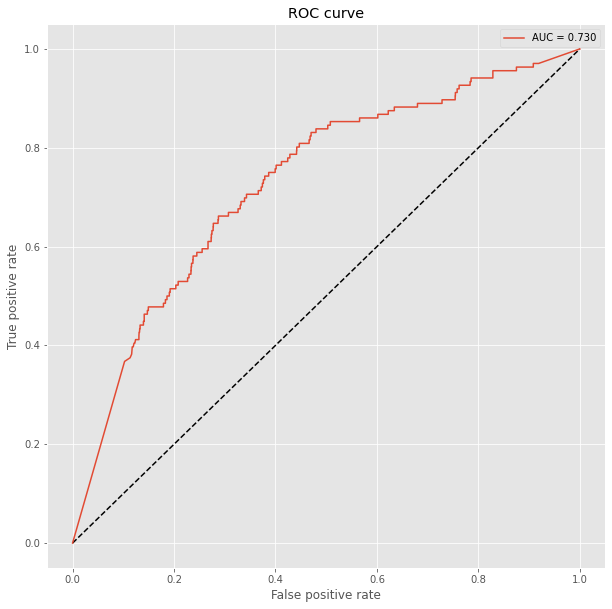

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for data in valloader:
    inputs,labels=data[0],data[1]
    
# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(labels[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(inputs).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();